In [1]:
import pickle
import rdkit

In [2]:
from oa_reactdiff.utils import xyz2mol

In [3]:
npz_path = "./oa_reactdiff/data/transition1x/train.pkl"
train_pkl = pickle.load(open(npz_path, "rb"))

In [4]:
train_pkl.keys()

dict_keys(['reactant', 'transition_state', 'product', 'single_fragment', 'use_ind'])

In [5]:
len(train_pkl["reactant"]["num_atoms"])

10073

In [6]:
for key, val in train_pkl.items():
    print(key)
    if isinstance(val, dict):
        subkey_list = list(val.keys())
        for subkey in subkey_list:
            temp = val[subkey]
            print(f"  {subkey}: {len(temp)} x {type(temp[-1])}")
            print(f"  {temp[1]}\n")
            print(f"  {temp[1999]}\n")
            print(f"  {temp[-1]}\n")
    else:
        print(val)
        print(len(val))
    print("")

reactant
  num_atoms: 10073 x <class 'int'>
  7

  11

  6

  charges: 10073 x <class 'list'>
  [np.int32(8), np.int32(6), np.int32(7), np.int32(7), np.int32(6), np.int32(1), np.int32(1)]

  [np.int32(7), np.int32(6), np.int32(6), np.int32(8), np.int32(6), np.int32(6), np.int32(7), np.int32(1), np.int32(1), np.int32(1), np.int32(1)]

  [np.int32(8), np.int32(6), np.int32(8), np.int32(7), np.int32(7), np.int32(8)]

  fragments: 10073 x <class 'list'>
  [[0, 1, 2, 3, 4, 5, 6]]

  [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]

  [[0, 1, 2, 3, 4, 5]]

  positions: 10073 x <class 'numpy.ndarray'>
  [[ 0.88309051  0.37047245 -0.04999968]
 [ 0.33719701 -0.39118644  0.92460784]
 [-0.89061084 -0.69941138  0.70060765]
 [-1.21696595 -0.10606412 -0.51449635]
 [-0.15437412  0.50233924 -0.90626395]
 [ 0.95788785 -0.65042981  1.76951508]
 [-0.00478637  1.08608953 -1.80283065]]

  [[ 1.98327533 -0.97078459  1.752481  ]
 [ 1.17994531 -1.10088797  0.93133143]
 [ 0.14103431 -1.21876758 -0.11468052]
 [-0.99244543 

In [7]:
for i in range(10073):
    reactant_charges = train_pkl["reactant"]["charges"][i]
    ts_charges = train_pkl["transition_state"]["charges"][i]
    product_charges = train_pkl["product"]["charges"][i]
    assert reactant_charges == ts_charges
    assert product_charges == ts_charges

In [8]:
atomic_num2sym = {
    1: 'H',    2: 'He',   3: 'Li',   4: 'Be',   5: 'B',    6: 'C',    7: 'N',    8: 'O',    9: 'F',    10: 'Ne',
    11: 'Na',  12: 'Mg',  13: 'Al',  14: 'Si',  15: 'P',   16: 'S',   17: 'Cl',  18: 'Ar',  19: 'K',   20: 'Ca',
    21: 'Sc',  22: 'Ti',  23: 'V',   24: 'Cr',  25: 'Mn',  26: 'Fe',  27: 'Co',  28: 'Ni',  29: 'Cu',  30: 'Zn',
    31: 'Ga',  32: 'Ge',  33: 'As',  34: 'Se',  35: 'Br',  36: 'Kr',  37: 'Rb',  38: 'Sr',  39: 'Y',   40: 'Zr',
    41: 'Nb',  42: 'Mo',  43: 'Tc',  44: 'Ru',  45: 'Rh',  46: 'Pd',  47: 'Ag',  48: 'Cd',  49: 'In',  50: 'Sn',
    51: 'Sb',  52: 'Te',  53: 'I',   54: 'Xe',  55: 'Cs',  56: 'Ba',  57: 'La',  58: 'Ce',  59: 'Pr',  60: 'Nd',
    61: 'Pm',  62: 'Sm',  63: 'Eu',  64: 'Gd', 65: 'Tb',  66: 'Dy',  67: 'Ho',  68: 'Er',  69: 'Tm',  70: 'Yb',
    71: 'Lu',  72: 'Hf',  73: 'Ta',  74: 'W',   75: 'Re',  76: 'Os',  77: 'Ir',  78: 'Pt',  79: 'Au',  80: 'Hg',
    81: 'Tl',  82: 'Pb',  83: 'Bi',  84: 'Po',  85: 'At',  86: 'Rn',  87: 'Fr',  88: 'Ra',  89: 'Ac',  90: 'Th',
    91: 'Pa',  92: 'U',   93: 'Np',  94: 'Pu',  95: 'Am',  96: 'Cm',  97: 'Bk',  98: 'Cf',  99: 'Es', 100: 'Fm',
    101: 'Md', 102: 'No', 103: 'Lr', 104: 'Rf', 105: 'Db', 106: 'Sg', 107: 'Bh', 108: 'Hs', 109: 'Mt', 110: 'Ds',
    111: 'Rg', 112: 'Cn', 113: 'Nh', 114: 'Fl', 115: 'Mc', 116: 'Lv', 117: 'Ts', 118: 'Og'
}

atomic_sym2num = {v:k for k, v in atomic_num2sym.items()}

In [9]:
# --- Importing and defining some functions ----
import torch
import py3Dmol
import numpy as np

from typing import Optional
from torch import tensor
from e3nn import o3
#from torch_scatter import scatter_mean

#from oa_reactdiff.model import LEFTNet

default_float = torch.float64
torch.set_default_dtype(default_float)  # Use double precision for more accurate testing



def draw_in_3dmol(mol: str, fmt: str = "xyz") -> py3Dmol.view:
    """Draw the molecule

    Args:
        mol (str): str content of molecule.
        fmt (str, optional): format. Defaults to "xyz".

    Returns:
        py3Dmol.view: output viewer
    """
    viewer = py3Dmol.view(1024, 576)
    viewer.addModel(mol, fmt)
    viewer.setStyle({'stick': {}, "sphere": {"radius": 0.36}})
    viewer.zoomTo()
    return viewer


def assemble_xyz(z: list, pos: tensor) -> str:
    """Assembling atomic numbers and positions into xyz format

    Args:
        z (list): chemical elements
        pos (tensor): 3D coordinates

    Returns:
        str: xyz string
    """
    natoms =len(z)
    xyz = f"{natoms}\n\n"
    for _z, _pos in zip(z, pos.numpy()):
        xyz += f"{_z}\t" + "\t".join([str(x) for x in _pos]) + "\n"
    return xyz

In [10]:
# single_fragment
# [1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
reaction_part = "product" # "reactant", "transition_state", or "product"
for i in range(5):
    z = [atomic_num2sym[int(x)] for x in train_pkl[reaction_part]["charges"][i]]
    pos = train_pkl[reaction_part]["positions"][i]
    if i == 2: # 0, 1, 2
        break
        
xyz = assemble_xyz(z, torch.tensor(pos))
view = draw_in_3dmol(xyz, "xyz")
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
from glob import glob
import plotly.express as px

from oa_reactdiff.analyze.rmsd import xyz2pmg, pymatgen_rmsd

from pymatgen.core import Molecule
from collections import OrderedDict


def draw_reaction(react_path: str, idx: int = 0, prefix: str = "gen") -> py3Dmol.view:
    """Draw the {reactants, transition states, products} of the reaction.

    Args:
        react_path (str): path to the reaction.
        idx (int, optional): index for the generated reaction. Defaults to 0.
        prefix (str, optional): prefix for distinguishing true sample and generated structure.
            Defaults to "gen".

    Returns:
        py3Dmol.view: _description_
    """
    with open(f"{react_path}/{prefix}_{idx}_react.xyz", "r") as fo:
        natoms = int(fo.readline()) * 3
    mol = f"{natoms}\n\n"
    for ii, t in enumerate(["react", "ts", "prod"]):
        pmatg_mol = xyz2pmg(f"{react_path}/{prefix}_{idx}_{t}.xyz")
        pmatg_mol_prime = Molecule(
            species=pmatg_mol.atomic_numbers,
            coords=pmatg_mol.cart_coords + 8 * ii,
        )
        mol += "\n".join(pmatg_mol_prime.to(fmt="xyz").split("\n")[2:]) + "\n"
    viewer = py3Dmol.view(1024, 576)
    viewer.addModel(mol, "xyz")
    viewer.setStyle({'stick': {}, "sphere": {"radius": 0.3}})
    viewer.zoomTo()
    return viewer

In [12]:
#!conda install conda-forge::scipy -y

In [13]:
for state in ["reactant", "transition_state", "product"]:
    val = train_pkl[state]
    print(list(val.keys()))

['num_atoms', 'charges', 'fragments', 'positions', 'rxn', 'wB97x_6-31G(d).energy', 'wB97x_6-31G(d).atomization_energy', 'wB97x_6-31G(d).forces', 'formula']
['num_atoms', 'charges', 'fragments', 'positions', 'rxn', 'wB97x_6-31G(d).energy', 'wB97x_6-31G(d).atomization_energy', 'wB97x_6-31G(d).forces', 'formula']
['num_atoms', 'charges', 'fragments', 'positions', 'rxn', 'wB97x_6-31G(d).energy', 'wB97x_6-31G(d).atomization_energy', 'wB97x_6-31G(d).forces', 'formula']


In [14]:
[int(len(x)==1) for x in train_pkl["product"]["fragments"]] == train_pkl["single_fragment"]

False

In [15]:
len(train_pkl["single_fragment"])

10073

In [16]:
len([int(len(x)==1) for x in train_pkl["product"]["fragments"]])

10073

In [17]:
[int(len(x)==1) for x in train_pkl["product"]["fragments"]][:10]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1]

In [18]:
train_pkl["single_fragment"][:10]

[1, 0, 1, 0, 1, 1, 1, 1, 1, 1]

In [19]:
product_derived_single_fragment_list = [int(len(x)==1) for x in train_pkl["product"]["fragments"]]
diff_counter = 0

for i in range(10073):
    if train_pkl["single_fragment"][i] == product_derived_single_fragment_list[i]:
        pass
    else:
        print(i)
        print(train_pkl["single_fragment"][i])
        print(product_derived_single_fragment_list[i])
        print(train_pkl["product"]["fragments"][i])
        diff_counter +=1 
        print("")

381
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

382
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

384
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

385
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

386
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

387
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

389
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

390
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]

394
0
1
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]



In [20]:
product_derived_single_fragment_list = [int(len(x)==1) for x in train_pkl["transition_state"]["fragments"]]

for i in range(10073):
    if train_pkl["single_fragment"][i] == product_derived_single_fragment_list[i]:
        pass
    else:
        num_fragments = len(train_pkl["transition_state"]["fragments"][i])
        print(f"{i}: {num_fragments}")
        if num_fragments == 2:
            print(train_pkl["transition_state"]["fragments"][i])
            break

4: 2
[[0, 4], [1, 2, 3, 5, 6]]


In [21]:
diff_counter

9

In [22]:
def draw_select(i: int, state: str = "product", dataset: dict = train_pkl, atomic_num2sym: dict = atomic_num2sym):
    z = [atomic_num2sym[int(x)] for x in dataset[state]["charges"][i]]
    pos = dataset[state]["positions"][i]
    xyz = assemble_xyz(z, torch.tensor(pos))
    view = draw_in_3dmol(xyz, "xyz")
    return view

In [23]:
view = draw_select(4, "reactant")
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [24]:
train_pkl["reactant"]["fragments"][4]

[[0, 1, 2, 3, 4, 5, 6]]

In [25]:
view = draw_select(4, "transition_state")
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [26]:
view = draw_select(4, "product")
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [27]:
train_pkl["product"]["fragments"][4]

[[0, 1, 2, 3, 4, 5, 6]]

# Can we segment  out the fragments into indices from just the XYZ positions?

In [28]:
#!conda list | grep xyz

In [29]:
import oa_reactdiff.utils.xyz2mol as x2m

In [30]:
atoms, charge, xyz_coordinates = x2m.read_xyz_file("/Users/trondlinjordet/projects/TMC-diffusion/scratch/epoch_179/molecule_000.xyz")

In [31]:
atoms[:10]

[1, 6, 1, 1, 1, 6, 6, 1, 1, 6]

In [32]:
charge

0

In [33]:
xyz_coordinates[:3]

[[3.343789101, -0.151275933, 0.629441321],
 [1.64488852, -3.379065037, -2.322920561],
 [1.259073138, -2.830734253, -2.567328215]]

In [34]:
i = 4
state = "transition_state"
dataset = train_pkl

z = [atomic_num2sym[int(x)] for x in dataset[state]["charges"][i]]
pos = dataset[state]["positions"][i]
xyz = assemble_xyz(z, torch.tensor(pos))

In [35]:
xyz

'7\n\nO\t-1.1342408328682998\t-1.3080152949230457\t-0.07721753751435742\nN\t-0.34740504603425243\t-0.06753354760656761\t-1.24385812676676\nC\t0.4246629344430722\t0.7522583373245038\t-0.611368308893331\nC\t0.012766259958973966\t1.3651818602055894\t0.6022239660342206\nN\t-1.357491520463228\t-1.1113870034279165\t1.0261485054201673\nH\t1.2590385548194645\t1.2136478908647483\t-1.166055829312216\nH\t-0.2567278471360374\t0.6963910887630244\t1.4364766734547174\n'

In [36]:
atoms = [atomic_sym2num[x] for x in z]
atoms

[8, 7, 6, 6, 7, 1, 1]

In [37]:
pos = [[float(y) for y in list(x)] for x in list(pos)]
pos

[[-1.1342408328682998, -1.3080152949230457, -0.07721753751435742],
 [-0.34740504603425243, -0.06753354760656761, -1.24385812676676],
 [0.4246629344430722, 0.7522583373245038, -0.611368308893331],
 [0.012766259958973966, 1.3651818602055894, 0.6022239660342206],
 [-1.357491520463228, -1.1113870034279165, 1.0261485054201673],
 [1.2590385548194645, 1.2136478908647483, -1.166055829312216],
 [-0.2567278471360374, 0.6963910887630244, 1.4364766734547174]]

In [38]:
xyz = assemble_xyz(z, torch.tensor(pos))
view = draw_in_3dmol(xyz, "xyz")
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [39]:
import networkx as nx

In [40]:
# Get the molobjs
mols = x2m.xyz2mol(
        atoms,
        pos,
        charge=0, # Unclear how to get this before starting with xyz2mol ... 
        use_graph=True, #quick,
        allow_charged_fragments=False,
        embed_chiral=False,
        use_huckel=False,
    )

[19:52:51] Explicit valence for atom # 0 O, 3, is greater than permitted


In [41]:
mols

[None]

## Interlude w Ruben

In [42]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDetermineBonds

In [43]:
mol_block = Chem.MolFromXYZBlock(xyz)
rdkit.Chem.rdDetermineBonds.DetermineConnectivity(mol_block)
##Chem.SanitizeMol(mol_block, Chem.SanitizeFlags.SANITIZE_ALL)
fragments = Chem.GetMolFrags(mol_block, asMols=True)

In [44]:
fragments

(<rdkit.Chem.rdchem.Mol at 0x151d2f5a0>,
 <rdkit.Chem.rdchem.Mol at 0x151d2f610>)

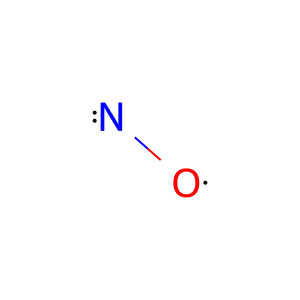

In [45]:
rdkit.Chem.Draw.MolToImage(fragments[0])

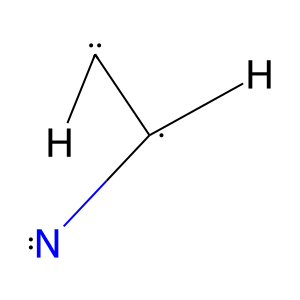

In [46]:
rdkit.Chem.Draw.MolToImage(fragments[1])

In [47]:
from pprint import pprint
pprint(xyz)

('7\n'
 '\n'
 'O\t-1.1342408328682998\t-1.3080152949230457\t-0.07721753751435742\n'
 'N\t-0.34740504603425243\t-0.06753354760656761\t-1.24385812676676\n'
 'C\t0.4246629344430722\t0.7522583373245038\t-0.611368308893331\n'
 'C\t0.012766259958973966\t1.3651818602055894\t0.6022239660342206\n'
 'N\t-1.357491520463228\t-1.1113870034279165\t1.0261485054201673\n'
 'H\t1.2590385548194645\t1.2136478908647483\t-1.166055829312216\n'
 'H\t-0.2567278471360374\t0.6963910887630244\t1.4364766734547174\n')


In [48]:
train_pkl["transition_state"]["fragments"][4]

[[0, 4], [1, 2, 3, 5, 6]]

In [49]:
mol_frag1 = fragments[0]

In [50]:
atom1 = mol_frag1.GetAtomWithIdx(1)

In [51]:
atom1.GetSymbol()

'N'

In [52]:
#mol_frag1
pprint(Chem.MolToXYZBlock(mol_frag1))

('2\n'
 '\n'
 'O     -1.134241   -1.308015   -0.077218\n'
 'N     -1.357492   -1.111387    1.026149\n')


In [53]:
Chem.MolToXYZBlock(mol_frag1)

'2\n\nO     -1.134241   -1.308015   -0.077218\nN     -1.357492   -1.111387    1.026149\n'

In [54]:
conf_frag1 = mol_frag1.GetConformer()

In [55]:
atom1_point3d = conf_frag1.GetAtomPosition(1)

In [56]:
atom1_point3d.x

-1.357491520463228

In [57]:
xyz_frag1 = Chem.MolToXYZBlock(mol_frag1)
xyz_list =  xyz_frag1.split("\n")
xyz_list[3].split()

['N', '-1.357492', '-1.111387', '1.026149']

In [58]:
xyz_list

['2',
 '',
 'O     -1.134241   -1.308015   -0.077218',
 'N     -1.357492   -1.111387    1.026149',
 '']

In [59]:
'N\t-1.357491520463228\t-1.1113870034279165\t1.0261485054201673\n'.split()

['N', '-1.357491520463228', '-1.1113870034279165', '1.0261485054201673']

In [60]:
frag_xyz_line = xyz_list[3].split()
data_xyz_line = 'N\t-1.357491520463228\t-1.1113870034279165\t1.0261485054201673\n'.split()

In [61]:
equals = []
for frag_x, data_x in zip(frag_xyz_line, data_xyz_line):
    if frag_x == data_x:
        equals.append(True)
    elif round(float(frag_x), 6) == round(float(data_x), 6):
        equals.append(True)
    else:
        equals.append(False)
equals

[True, True, True, True]

In [62]:
all(equals)

True

OK, now I know roughly what  to do to at least check if we can get the  right fragments.

In [63]:
bool("")

False

In [64]:
def determine_equal_xyz_lines(frag_xyz_line: str, total_xyz_line: str) -> bool:
    frag_xyz_list = frag_xyz_line.split()
    total_xyz_list = total_xyz_line.split()
    for temp in [frag_xyz_list, total_xyz_list]:
        assert isinstance(temp, list)
        assert len(temp) == 4
    equals = []
    for frag_x, total_x in zip(frag_xyz_list, total_xyz_list):
        converted = False
        try:
            frag_x = float(frag_x)
            total_x = float(total_x)
            converted = True
        except:
            pass    
        if frag_x == total_x:
            equals.append(True)
        elif converted and (round(float(frag_x), 6) == round(float(total_x), 6)):
            equals.append(True)
        else:
            equals.append(False)
    return all(equals)

In [65]:
def get_fragments(xyz_tuple: tuple, bond_cov_factor: float=1.3, useHueckel: bool=False) -> list:
    z, pos = xyz_tuple
    mols = [] # list of Mols
    for q in [0,1,-1,2,-2]:
        try:
            mols = xyz2mol.xyz2mol(z, pos, charge=q)
        except: # Exception as e:
            continue
        if mols:
            break
    if len(mols) == 0:
        print("no Mols created! Returning a single fragment (index list) by default.")
        return [[x for x in range(len(z))]]
    fragments = rdkit.Chem.GetMolFrags(mols[0])
    return [list(x) for x in fragments]
    
    #fragmols = Chem.GetMolFrags(mol_block, asMols=True, sanitizeFrags=False)
    #fragments = []
    #z_sym = [atomic_num2sym[int(x)] for x in z]
    #xyz = assemble_xyz(z_sym, torch.tensor(pos))
    #total_xyz_lines = xyz.split("\n")[2:]
    #if total_xyz_lines[-1] == "":
    #    total_xyz_lines = total_xyz_lines[:-1]
    #for i, mol in enumerate(fragmols):
    #    fragment = []
    #    print(mol)
    #    frag_xyz = Chem.MolToXYZBlock(mol)
    #    #print(f"Fragment {i}:")
    #    #print(frag_xyz)
    #    frag_xyz_lines = frag_xyz.split("\n")[2:]
    #    if frag_xyz_lines[-1] == "":
    #        frag_xyz_lines = frag_xyz_lines[:-1]
    #    for j, total_xyz_line in enumerate(total_xyz_lines):
    #        for frag_xyz_line in frag_xyz_lines:
    #            if determine_equal_xyz_lines(frag_xyz_line, total_xyz_line):
    #                fragment.append(j)
    #                #print(total_xyz_line)
    #    fragments.append(fragment)

    return fragments

In [66]:
# Second suggestion from RS:
import networkx as nx

def get_fragments3(xyz_tuple: tuple, bond_cov_factor: float=1.3, useHueckel: bool=False) -> list:
    z, pos = xyz_tuple
    AC, _ = xyz2mol.xyz2AC_vdW(z, pos)
    return [list(frag) for frag in nx.connected_components(nx.Graph(AC))]

In [67]:
# Spontaneous "TDD", live cell
i = 4
state = "transition_state"
dataset = train_pkl

#z = [atomic_num2sym[int(x)] for x in dataset[state]["charges"][i]]
z = [int(x) for x in dataset[state]["charges"][i]]
pos = dataset[state]["positions"][i]
test_xyz = tuple([z, pos]) #assemble_xyz(z, torch.tensor(pos))

test_fragments = [[0, 4], [1, 2, 3, 5, 6]] # fragments of transition state for i=4
test_xyz

([8, 7, 6, 6, 7, 1, 1],
 array([[-1.13424083, -1.30801529, -0.07721754],
        [-0.34740505, -0.06753355, -1.24385813],
        [ 0.42466293,  0.75225834, -0.61136831],
        [ 0.01276626,  1.36518186,  0.60222397],
        [-1.35749152, -1.111387  ,  1.02614851],
        [ 1.25903855,  1.21364789, -1.16605583],
        [-0.25672785,  0.69639109,  1.43647667]]))

In [68]:
z, pos = test_xyz # xyz_tuple
mols = [] # list of Mols
for q in [0,1,-1,2,-2]:
    mols = xyz2mol.xyz2mol(z, pos, charge=q)
    if mols:
        break
if len(mols) == 0:
    print("no Mols created! Returning a single fragment (index list) by default.")
    #return [[x for x in range(len(z))]]
mol_frags = rdkit.Chem.GetMolFrags(mols[0])
#fragmols = Chem.GetMolFrags(mol_block, asMols=True, sanitizeFrags=False)
fragments = []

In [71]:
mols

In [72]:
my_fragments = get_fragments(test_xyz)
#assert test_fragments == my_fragments

In [73]:
my_fragments

[[0, 4], [1, 2, 3, 5, 6]]

Next, roll out and test all the geometries to see if all or at least most fragmentations are matched.

In [74]:
'O     -1.134241   -1.308015   -0.077218'.split()

['O', '-1.134241', '-1.308015', '-0.077218']

In [75]:
'O     -1.134241   -1.308015   -0.077218'.split()

['O', '-1.134241', '-1.308015', '-0.077218']

In [76]:
def assemble_xyz(atom_symbols, positions: torch.Tensor) -> str:
    """
    Assembles an XYZ string from atom symbols and torch tensor positions.
    Ensures robust formatting of coordinates for RDKit parsing.

    Args:
        atom_symbols (list[str]): List of atomic symbols (e.g., ['C', 'H', 'H']).
        positions (torch.Tensor): A Nx3 torch tensor of atomic coordinates.

    Returns:
        str: The formatted XYZ string.
    """
    num_atoms = len(atom_symbols)
    xyz_lines = [str(num_atoms), "Generated by assemble_xyz"]

    for i in range(num_atoms):
        symbol = atom_symbols[i]
        # Format coordinates to a reasonable number of decimal places (e.g., 6)
        # Using 'f' format ensures fixed-point notation, avoiding 'e-XX' for small numbers.
        # This is CRUCIAL for RDKit's MolFromXYZBlock to parse correctly.
        x = f"{positions[i, 0]:.6f}"
        y = f"{positions[i, 1]:.6f}"
        z = f"{positions[i, 2]:.6f}"
        xyz_lines.append(f"{symbol}  {x}  {y}  {z}")

    return "\n".join(xyz_lines)

In [77]:
match_count = 0
match_counts = []
printing = True #False

dataset = train_pkl
for state in ["transition_state"]: #["reactant", "transition_state", "product"]:
    state_match_count = 0
    for i in range(10073):
        if i%5000 == 0:
            print(f"{state}: {i} progress.")
        ref_fragments = dataset[state]["fragments"][i]
        z_sym = [atomic_num2sym[int(x)] for x in dataset[state]["charges"][i]]
        z = [int(x) for x in dataset[state]["charges"][i]]
        pos = dataset[state]["positions"][i]
        xyz_tuple = tuple([z, pos])
        xyz = assemble_xyz(z_sym, torch.tensor(pos))
        bond_cov_factor=1.3
        if state == "transition_state":
            bond_cov_factor=1.17274375
        my_fragments = get_fragments3(xyz_tuple, bond_cov_factor=bond_cov_factor)
        if my_fragments == ref_fragments:
            match_count += 1
            state_match_count += 1
        elif len(my_fragments) == len(ref_fragments):
            equals = []
            for my_frag, ref_frag in zip(my_fragments, ref_fragments):
                if set(my_frag) == set(ref_frag):
                    equals.append(True)
                else:
                    equals.append(False)
            if all(equals):
                match_count += 1
                state_match_count += 1
            else:
                pass
                print(f"{state}: {i}:")
                print(ref_fragments)
                print(my_fragments)
                print("")
        elif printing and i==8526:
            print(f"{state}: {i}:")
            print(ref_fragments)
            print(my_fragments)
            print("")
    match_counts.append(state_match_count)

transition_state: 0 progress.
transition_state: 5000 progress.
transition_state: 8526:
[[0, 8, 9, 7], [1, 2, 3, 4, 5, 6, 10, 11, 12, 13, 14, 15, 16]]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]]

transition_state: 10000 progress.


In [78]:
view = draw_select(5, "transition_state")
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [79]:
match_count /(3*10073)
# covFactor=bond_cov_factor results so far: 
# covFactor=1.3:     0.8365928720341507 (default)
# covFactor=1.25:    0.9283894238723982
# covFactor=1.25:    0.9283894238723982 (disgard index order inside individual fragment)
# covFactor=1.2:     0.9283894238723982
# covFactor=1.1:     0.9283894238723982
# covFactor=0.9:     0.9283894238723982

# OK so maybe reactant and product are already perfect, only transition state fragmentation is different?

0.23902180747212018

In [80]:
3*10073

30219

In [81]:
match_counts

[7223]

In [82]:
match_count/10073

0.7170654224163606

In [ ]:
# if state == "transition_state":
#            bond_cov_factor=0.5 :          0.6422118534696714
#            bond_cov_factor=0.6 :          0.642
#            bond_cov_factor=1.3 :          0.6422118534696714
#            bond_cov_factor=1.1 :          0.6771567556835104 # Now using van der Waals method!
#            bond_cov_factor=1.2 :          0.8889109500645289 # Now using van der Waals method!
#            bond_cov_factor=1.25 :         0.7948972500744564 # Now using van der Waals method!
#            bond_cov_factor=1.15 :         0.8655812568251762 # Now using van der Waals method!
#            bond_cov_factor=1.18 :         0.929613819120421 # Now using van der Waals method!
#            bond_cov_factor=1.17 :         0.9357688871239949 # Now using van der Waals method!
#            bond_cov_factor=1.19 :         0.9121413680135014 # Now using van der Waals method!
#            bond_cov_factor=1.16 :         0.9017174625235779 # Now using van der Waals method!
#            bond_cov_factor=1.165 :        0.9212746947284821 # Now using van der Waals method!
#            bond_cov_factor=1.175 :        0.9357688871239949 # Now using van der Waals method!
#            bond_cov_factor=1.1755 :       0.9351732353817135 # Now using van der Waals method!
#            bond_cov_factor=1.1675 :       0.9281246897647175 # Now using van der Waals method!
#            bond_cov_factor=1.1725 :       0.9398391740295841 # Now using van der Waals method!
#            bond_cov_factor=1.173 :        0.9397398987392038 # Now using van der Waals method!
#            bond_cov_factor=1.1735 :       0.9387471458354015 # Now using van der Waals method!
#            bond_cov_factor=1.17325 :      0.9392435222873027 # Now using van der Waals method!
#            bond_cov_factor=1.17275 :      0.9400377246103445 # Now using van der Waals method!*
#            bond_cov_factor=1.172625 :     0.9397398987392038 # Now using van der Waals method!
#            bond_cov_factor=1.172675 :     0.9398391740295841 # Now using van der Waals method
#            bond_cov_factor=1.172725 :     0.9399384493199643 # Now using van der Waals method!
#            bond_cov_factor=1.1727375 :    0.9400377246103445 # Now using van der Waals method!*

#            bond_cov_factor=1.17274375 :   0.9400377246103445 # Now using van der Waals method!*

In [ ]:
(1.17275+1.1727375)/2

In [ ]:
match_count

In [ ]:
view = draw_select(8526, "transition_state")
view

In [83]:
view = draw_select(3, "transition_state")
view

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
import numpy

In [ ]:
def get_ts_fragment_reprod_accuracy(ts_threshold: float = 1.17274375, dataset: dict = train_pkl, states: list = ["transition_state"], atomic_num2sym: dict=atomic_num2sym) -> float:
    ts_threshold = float(ts_threshold)
    match_count = 0
    match_counts = []
    printing = True #False
    
    total_length = 0
    for state in states: #["reactant", "transition_state", "product"]:
        total_length += len(dataset[state]["fragments"])
        state_match_count = 0
        for i in range(len(dataset[state]["fragments"])):
            #if i%5000 == 0:
            #    print(f"{state}: {i} progress.")
            ref_fragments = dataset[state]["fragments"][i]
            z = [atomic_num2sym[int(x)] for x in dataset[state]["charges"][i]]
            pos = dataset[state]["positions"][i]
            xyz = assemble_xyz(z, torch.tensor(pos))
            bond_cov_factor=1.3
            if state == "transition_state":
                bond_cov_factor = float(ts_threshold)
            my_fragments = get_fragments(xyz, bond_cov_factor=bond_cov_factor)
            if my_fragments == ref_fragments:
                match_count += 1
                state_match_count += 1
            elif len(my_fragments) == len(ref_fragments):
                equals = []
                for my_frag, ref_frag in zip(my_fragments, ref_fragments):
                    if set(my_frag) == set(ref_frag):
                        equals.append(True)
                    else:
                        equals.append(False)
                if all(equals):
                    match_count += 1
                    state_match_count += 1
          #      else:
          #          print(f"{state}: {i}:")
          #          print(ref_fragments)
          #          print(my_fragments)
          #          print("")
          #  elif printing: # and i==8526:
          #      print(f"{state}: {i}:")
          #      print(ref_fragments)
          #      print(my_fragments)
          #      print("")
        match_counts.append(state_match_count)
    return -match_count/total_length

In [ ]:
get_ts_fragment_reprod_accuracy(1.17274375)

In [ ]:
from scipy.optimize import minimize

In [ ]:
res1 = minimize(get_ts_fragment_reprod_accuracy, 1.17274375)

In [ ]:
res1.x

In [ ]:
from oa_reactdiff.utils import xyz2mol

In [ ]:
# Spontaneous "TDD", live cell
i = 4
state = "transition_state"
dataset = train_pkl

atomic_numbers = [int(x) for x in dataset[state]["charges"][i]]

#z = [atomic_num2sym[int(x)] for x in dataset[state]["charges"][i]]
positions = dataset[state]["positions"][i]
#test_xyz = assemble_xyz(z, torch.tensor(pos))

test_fragments = [[0, 4], [1, 2, 3, 5, 6]] # fragments of transition state for i=4
#my_fragments = get_fragments(test_xyz)
#assert test_fragments == my_fragments
print(atomic_numbers)
print(positions)

In [ ]:
# Second suggestion from RS:
import networkx as nx
AC, _ = xyz2mol.xyz2AC_vdW(atomic_numbers, positions)
frags = [list(frag) for frag in nx.connected_components(nx.Graph(AC))]

In [ ]:
frags

In [ ]:
positions

In [ ]:
xyz2mol.xyz2mol?
#(atomic_numbers, positions)

In [ ]:
positions = [[round(float(y), 6) for y in list(x)] for x in list(positions)]
positions

In [ ]:
xyz2mol.xyz2mol(atomic_numbers, positions)

In [ ]:
rdkit.Chem.GetMolFrags(xyz2mol.xyz2mol(atomic_numbers, positions)[0])